In [2]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [ ]:
%%time

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}

days = 14
num_timesteps = 24 * days
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}

initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    #     speculators # folks speculating on clover coin price
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f91fd4320f0>]


In [19]:
%%time

def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        substep = row['substep']
        run = row['run']
        s = row['s']
        g = s['network']
        new_cols = {}

        
        players = utils.get_nodes_by_type(g, 'player')
        clovers = utils.get_nodes_by_type(g, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward

        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(s['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)

# adding new useful columns for graphing
full_df['coin-price'] = utils.calculateCurrentPrice(
    (full_df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (full_df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])


full_df

CPU times: user 6.77 s, sys: 3.84 ms, total: 6.78 s
Wall time: 6.77 s


In [21]:
df = full_df[full_df['substep'] == 2] # after player policy

df

,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,players,reward-rotSym,reward-x0Sym,reward-xnySym,reward-xySym,reward-y0Sym,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price
2,40,40.001993,30309.814289,41,41,30,2.100000,1.050000,0.200000,0.247059,2.100000,1,1,2,1,3,20,16,1,0.001681
5,77,40.001993,30328.273258,78,78,30,2.633333,0.987500,0.207895,0.292593,1.128571,2,1,2,2,7,37,26,6,0.001680
8,54,40.525369,30350.486224,122,122,30,1.757143,1.230000,0.227778,0.279545,1.025000,6,1,2,3,9,53,43,11,0.001692
11,71,40.706544,30369.042685,161,161,30,2.025000,1.080000,0.234783,0.279310,1.012500,7,1,2,4,14,68,57,15,0.001696
14,116,40.699557,30394.730526,208,208,30,1.741667,0.950000,0.245882,0.278667,1.100000,11,1,2,5,21,84,74,18,0.001696
17,137,40.991679,30416.611592,251,251,30,1.680000,0.969231,0.244660,0.286364,1.050000,14,1,2,6,25,102,87,23,0.001702
20,131,41.507481,30437.175477,290,290,30,1.531579,0.881818,0.246610,0.291000,1.164000,18,1,2,7,32,117,99,24,0.001714
23,168,41.471986,30452.714573,327,327,30,1.726316,0.886486,0.242963,0.292857,1.131034,18,1,2,8,36,134,111,28,0.001713
26,186,41.668341,30465.731142,368,368,30,1.845000,0.878571,0.247651,0.277444,1.272414,19,1,2,9,41,148,132,28,0.001717
29,224,41.645213,30480.103279,406,406,30,2.030000,0.902222,0.241667,0.280000,1.268750,19,1,2,10,44,167,144,31,0.001716


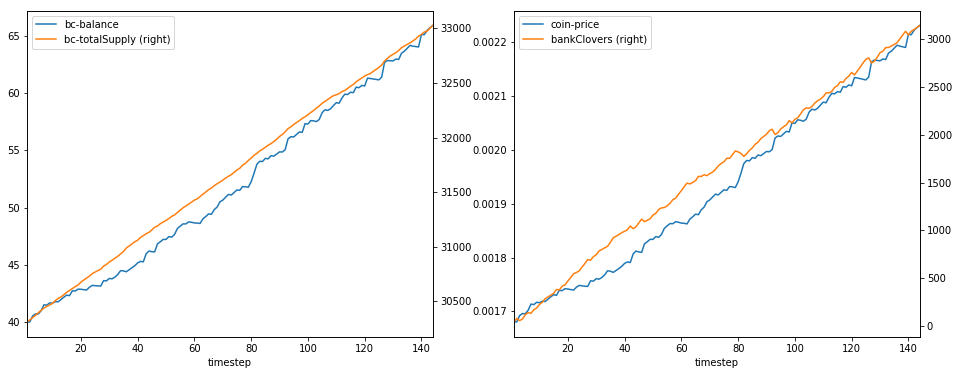

In [22]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[run,1])

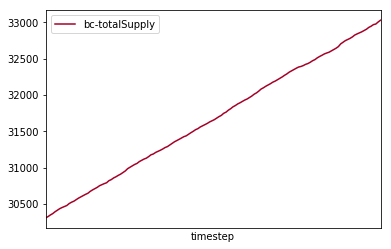

In [23]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn',
       )

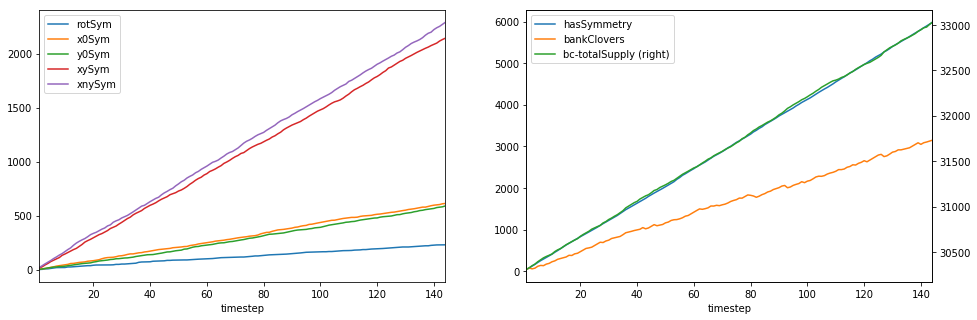

In [24]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

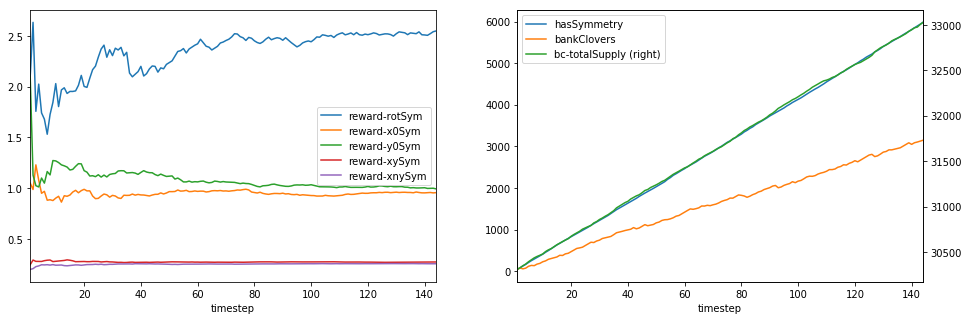

In [25]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

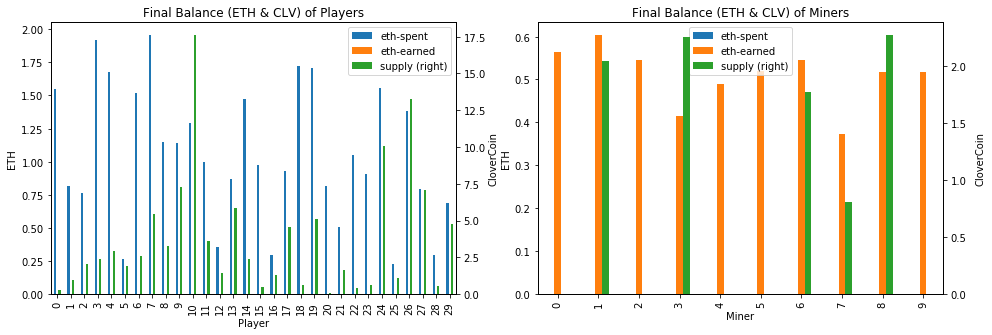

In [26]:
final_state = raw_result[-1]['s']
g = final_state['network']
miners = utils.get_nodes_by_type(g, 'miner')
players = utils.get_nodes_by_type(g, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(16,(row_height*num_runs)))
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if num_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if num_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
        pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])

Text(0.5, 51.0, 'Timestep')

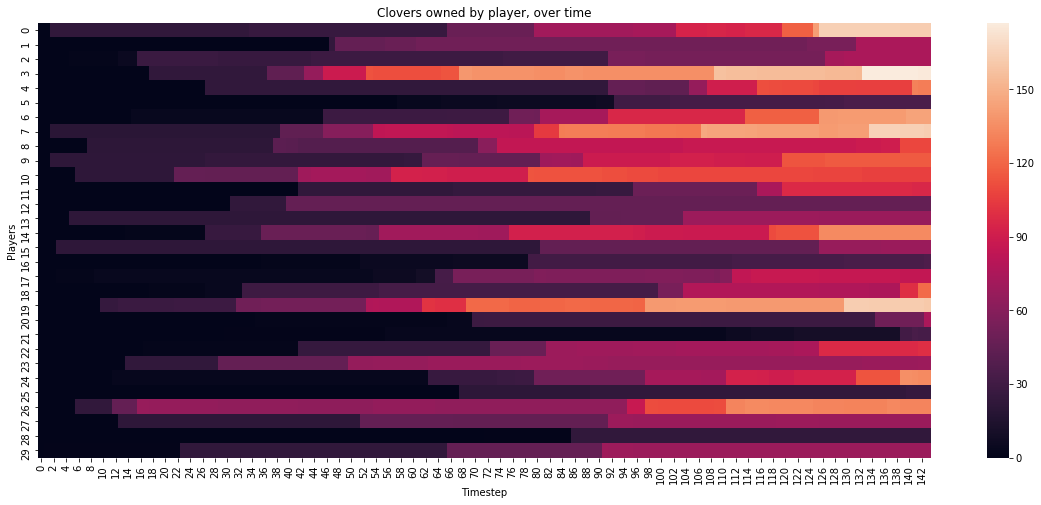

In [27]:
players = utils.get_nodes_by_type(raw_result[1]['s']['network'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = len(list(g.successors(i_ind)))

dims = (20, 8)
# adjust the dimensions

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

Text(0.5, 24.0, 'Timestep')

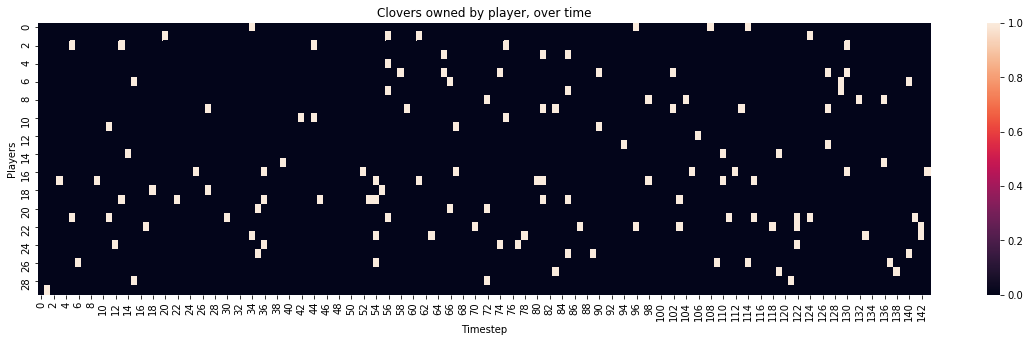

In [29]:
players = utils.get_nodes_by_type(raw_result[1]['s']['network'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in players:
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        affinities[i_ind][j_ind] = g.nodes[i_ind]['is_active']

dims = (20, 5)

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

In [31]:
#raw_result

In [32]:



pdf

,cash_out_threshold,eth-earned,eth-spent,hashrate,is_active,supply,type
0,0.01,0.563160,0,16.252745,0.7,0.000000,miner
1,0.01,0.603208,0,18.442539,0.7,2.039158,miner
2,0.01,0.544819,0,15.536785,0.7,0.000000,miner
3,0.01,0.414257,0,12.532788,0.7,2.254877,miner
4,0.01,0.489678,0,14.360305,0.7,0.000000,miner
5,0.01,0.519330,0,15.095042,0.7,0.000000,miner
6,0.01,0.545792,0,16.017206,0.7,1.767136,miner
7,0.01,0.371816,0,12.001198,0.7,0.802961,miner
8,0.01,0.516612,0,15.039522,0.7,2.267598,miner
9,0.01,0.516893,0,15.433068,0.7,0.000000,miner


In [33]:
g = raw_result[60]['network']

clovers = utils.get_nodes_by_type(g, 'clover')

g.nodes[clovers[5]]

p = g.nodes[5]

KeyError: 'network'

In [21]:
p['newField'] = 23

In [22]:
p

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [23]:
g.nodes[5]

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [7]:
clovers = [{'me': 'you'}, {'me': 'other'}, {'you': 'me'}]

In [8]:
[foo for foo in clovers if foo['me'] == 'you']

KeyError: 'me'

In [10]:
from scipy.stats import norm

norm.interval(0.999)

(-3.2905267314918945, 3.2905267314919255)

NameError: name 'g' is not defined

In [38]:
import networkx as nx
g = nx.DiGraph()

for i in range(5):
    g.add_node(i)
    
g.add_edge(2,3)
g.add_edge(1,3)
g.add_edge(1,2)
print("original edges:")
for i in g.edges():
    print(i)

ebunch = list(g.edges(1))
g.remove_edges_from(ebunch)
    
print("new edges:")
for i in g.edges():
    print(i)

original edges:
(1, 3)
(1, 2)
(2, 3)
new edges:
(2, 3)


In [34]:
ebunch = g.edges(1)

g.remove_edges_from(ebunch)

NameError: name 'g' is not defined

In [36]:
g.edges(1)

OutEdgeDataView([])

In [105]:
from numpy.random import rand
import numpy as np
from scipy.stats import norm

cloverObjValue = 0
stdDev = 1
playerId = 20
cloverId = 5
np.random.seed([playerId,cloverId])
norm.rvs(loc=cloverObjValue,scale=stdDev)

-0.3875415218651566

In [82]:
rand()

0.6221087710398319

In [46]:
{"foo": "bar", "clover": "other"}

{'foo': 'bar', 'clover': 'other'}

In [25]:
raw_result[30]

{'s': {'bc-balance': 62.06655250377233,
  'bc-totalSupply': 32183.32228269765,
  'symmetries': {'hasSymmetry': 357,
   'rotSym': 8,
   'y0Sym': 35,
   'x0Sym': 40,
   'xySym': 140,
   'xnySym': 129},
  'network': <networkx.classes.digraph.DiGraph at 0x7f30fa2691d0>},
 'run': 1,
 'substep': 1,
 'timestep': 30}

In [28]:
def test_function():
    s = raw_result[30]
    _input = policies.player_policy([params], None, None, s)
    return state_updates.update_state(None, None, None, s, _input)

%lprun -f utils.processBuysAndSells test_function()

In [33]:
foo = {'me': 2}

if 'me' in foo:
    print(1)

1
